**Rotator Trajectory Verification**

This Jupyter notebook is used to verify the updated rotator trajectory generator by Tekniker.
The test will be performed on summit with the real hardware.
Before that, the Tucson test stand is used to develop the test procedure.
The rotator commandable SAL component (CSC) is used to control the rotator hardware.
The published event and telemetry are stored in the engineering facility database (EFD).

It is noted that the **MTMount** telemetry data is required.
Otherwise, the rotator CSC will put the low-level controller into the **Fault** state.

The **setup** notebook can be used to bring up rotator and mount/CCW.

**Import Modules**

In [1]:
%matplotlib inline
%matplotlib widget
import asyncio
from datetime import datetime
import time
from astropy.time import Time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lsst.ts import salobj
from lsst.ts import simactuators
from lsst_efd_client import EfdClient

**Custom Functions**

In [2]:
def retrieve_efd_client(is_summit=True):
    """
    Retrieves a client to EFD.

    Parameters
    ----------
    is_summit : bool, optional
        This notebook is running on the summit or not. If not, the returned object will point
        to the test stand at Tucson.

    Returns
    -------
    EfdClient : The interface object between the Nublado and summit/Tucson EFD.
    """
    efd_name = "summit_efd" if is_summit else "tucson_teststand_efd"        
    return EfdClient(efd_name)

In [3]:
async def print_summary_state(csc):
    """
    Print the summary state of rotator.

    Parameters
    ----------
    csc : lsst.ts.salobj.remote.Remote
        Remote object of the rotator CSC.
    """
    data = await csc.evt_summaryState.aget(timeout=30)
    print(salobj.State(data.summaryState))

In [4]:
async def print_rotator_position(csc):
    """
    Print the rotator position in degree.

    Parameters
    ----------
    csc : lsst.ts.salobj.remote.Remote
        Remote object of the rotator CSC.
    """
    data = await csc.tel_rotation.aget(timeout=15)
    print(f"Rotator is at {data.actualPosition} degree.")

In [5]:
async def print_rotator_latest_message(csc):
    """
    Print the latest message of rotator.

    Parameters
    ----------
    csc : lsst.ts.salobj.remote.Remote
        Remote object of the rotator CSC.
    """
    data = await csc.evt_logMessage.aget(timeout=15)
    print(data.message)

In [6]:
def script_log_start(controller_script, test_title, test_detail):
    """Log the start of test case in script controller.

    Parameters
    ----------
    controller_script : lsst.ts.salobj.controller.Controller
        Script controller.
    test_title : str
        Test title.
    test_detail : str
        Test detail.

    Returns
    -------
    astropy.time.core.Time
        Time object.
    """
    time_now = datetime.now()
    controller_script.log.info(f"START -- {test_title} -- LVV-T2539 -- {test_detail} -- Starting Time: {time_now} UTC")
    return Time(time_now.isoformat(), scale="utc", format="isot")

In [7]:
def script_log_stop(controller_script, test_title, test_detail):
    """Log the stop of test case in script controller.

    Parameters
    ----------
    controller_script : lsst.ts.salobj.controller.Controller
        Script controller.
    test_title : str
        Test title.
    test_detail : str
        Test detail.

    Returns
    -------
    astropy.time.core.Time
        Time object.
    """
    time_now = datetime.now()
    controller_script.log.info(f"STOP -- {test_title} -- LVV-T2539 -- {test_detail} -- Starting Time: {time_now} UTC")
    return Time(time_now.isoformat(), scale="utc", format="isot")

In [8]:
def generate_tracking_target(position, velocity, period):
    """
    Generate the tracking target.

    Parameters
    ----------
    position : float
        Initial position of target in deg.
    velocity : float
        Velocity of the target in deg/sec.
    period : float
        Period to track in second.

    Returns
    -------
    list_position : list
        List of the position.
    list_velocity : list
        List of the velocity.
    """
    # 20 Hz is 0.05 s
    delta_t = 0.05
    number_total_commands = int(period / delta_t)
    
    list_position = [position + velocity * idx for idx in range(0, number_total_commands)]
    list_velocity = [velocity] *  number_total_commands
    return list_position, list_velocity

In [32]:
async def slew_test(csc, position, est_time_wait, est_time_stop):
    """
    Slew test. The rototator will move in the positive and negative directions.
    It will stop in the final movement.

    Parameters
    ----------
    csc : lsst.ts.salobj.remote.Remote
        Remote object of the rotator CSC.
    est_time_wait : float
        Estimated time to wait of movement in second.
    est_time_stop : float
        Estimated time to stop in the final in second.
    """
    # Move in one direction
    await csc.cmd_move.set_start(position=position, timeout=60)
    await asyncio.sleep(est_time_wait)
    
    print("arrived 1")
    # Move back to the origin
    await csc.cmd_move.set_start(position=0, timeout=60)
    await asyncio.sleep(est_time_wait)
    print("arrived 2")
    # Move to the other direction
    await csc.cmd_move.set_start(position=-position, timeout=60)
    await asyncio.sleep(est_time_wait)
    print("arrived 3")
    # Move and stop before the end of movement
    await csc.cmd_move.set_start(position=position, timeout=60)
    await asyncio.sleep(est_time_stop)
    await csc.cmd_stop.set_start(timeout=60)

In [10]:
async def track_target(csc, start_position, end_position, velocity):
    """Track the target.

    Parameters
    ----------
    start_position : float
        Starting position of ramp (deg).
    end_position : float
        Ending position of ramp (deg).
    velocity : float
        Velocity of motion along the ramp (deg/sec).
    """
    # 20 Hz is 0.05 ms
    track_advance_time = 0.05
    ramp_generator = simactuators.RampGenerator(
        [start_position], [end_position], [velocity], track_advance_time)

    await csc.cmd_trackStart.start(timeout=15)
    for positions, velocities, tai in ramp_generator():
        await csc.cmd_track.set_start(
            angle=positions[0],
            velocity=velocities[0],
            tai=tai,
            timeout=5,
        )
        await asyncio.sleep(0.1)

In [114]:
async def track_slew_test(csc):
    """
    Track slew sequence test.

    Parameters
    ----------
    csc : lsst.ts.salobj.remote.Remote
        Remote object of the rotator CSC.
    """
    # 20 Hz is 0.05 ms
    track_advance_time = 0.05
    ramp_generator_1 = simactuators.RampGenerator([0.7], [1.5], [0.068], track_advance_time)
    ramp_generator_2 = simactuators.RampGenerator([0.7], [0], [-0.068], track_advance_time)
    ramp_generator_3 = simactuators.RampGenerator([5], [4.7], [-0.01], track_advance_time)
    ramp_generator_4 = simactuators.RampGenerator([-5], [-4.6], [0.0042], track_advance_time)

    # Track the first target
    await csc.cmd_trackStart.start(timeout=15)

    is_stopped = False
    time_start = time.monotonic()
    for positions, velocities, tai in ramp_generator_1():
        await csc.cmd_track.set_start(
            angle=positions[0],
            velocity=velocities[0],
            tai=tai,
            timeout=5,
        )
        await asyncio.sleep(0.1)

        # Stop the rotator in the tracking
        delta_time = time.monotonic() - time_start
        if (3 <= delta_time <= 3.5) and (not is_stopped):
            await csc.cmd_stop.set_start(timeout=10)
            
            await asyncio.sleep(1)
            is_stopped = True
            print("check point 1")

        # Allow the tracking again
        if is_stopped:
            await csc.cmd_trackStart.start(timeout=15)
            is_stopped = False
            print("check point 2")
            
    print("check point 3")

    # Track the second target
    for positions, velocities, tai in ramp_generator_2():
        await csc.cmd_track.set_start(
            angle=positions[0],
            velocity=velocities[0],
            tai=tai,
            timeout=5,
        )
        await asyncio.sleep(0.1)
        
    print("check point 4")

    # Track the third target
    for positions, velocities, tai in ramp_generator_3():
        await csc.cmd_track.set_start(
            angle=positions[0],
            velocity=velocities[0],
            tai=tai,
            timeout=5,
        )
        await asyncio.sleep(0.1)
        
    print("check point 5")

    # Track the fourth target
    for positions, velocities, tai in ramp_generator_4():
        await csc.cmd_track.set_start(
            angle=positions[0],
            velocity=velocities[0],
            tai=tai,
            timeout=5,
        )
        await asyncio.sleep(0.1)
        
    print("check point 6")

In [153]:
async def slew_supersession_test(csc):
    """
    Slew supersession test.

    Parameters
    ----------
    csc : lsst.ts.salobj.remote.Remote
        Remote object of the rotator CSC.
    """
    # 20 Hz is 0.05 ms
    track_advance_time = 0.05
    ramp_generator_1 = simactuators.RampGenerator([60], [62], [0.068], track_advance_time)
    ramp_generator_2 = simactuators.RampGenerator([-60], [-62], [-0.05], track_advance_time)

    # Track the first target
    await csc.cmd_trackStart.start(timeout=15)

    is_stopped = False
    time_start = time.monotonic()
    for positions, velocities, tai in ramp_generator_1():
        await csc.cmd_track.set_start(
            angle=positions[0],
            velocity=velocities[0],
            tai=tai,
            timeout=5,
        )
        await asyncio.sleep(0.1)

        # Break the tracking of this target to test the supersession of slew
        if (time.monotonic() - time_start) > 8:
            print("check point 1")
            break
            
    print("check point 2")

    # Track the second target
    for positions, velocities, tai in ramp_generator_2():
        await csc.cmd_track.set_start(
            angle=positions[0],
            velocity=velocities[0],
            tai=tai,
            timeout=5,
        )
        await asyncio.sleep(0.1)
        
    print("check point 3")

In [182]:
async def track_slew_multiple_stop_test(csc):
    """
    Track slew sequence test with multiple stops.

    Parameters
    ----------
    csc : lsst.ts.salobj.remote.Remote
        Remote object of the rotator CSC.
    """
    # 20 Hz is 0.05 ms
    track_advance_time = 0.05
    ramp_generator_1 = simactuators.RampGenerator([0.7], [1.5], [0.068], track_advance_time)
    ramp_generator_2 = simactuators.RampGenerator([0.7], [0], [-0.068], track_advance_time)

    # Track the first target
    await csc.cmd_trackStart.start(timeout=15)

    is_stopped = False
    time_start = time.monotonic()
    for positions, velocities, tai in ramp_generator_1():
        await csc.cmd_track.set_start(
            angle=positions[0],
            velocity=velocities[0],
            tai=tai,
            timeout=5,
        )
        await asyncio.sleep(0.1)

        # Stop the rotator in the tracking
        delta_time = time.monotonic() - time_start
        if ((3 <= delta_time <= 3.5) or (6 <= delta_time <= 6.5)) and (not is_stopped):
            await csc.cmd_stop.set_start(timeout=10)
            
            await asyncio.sleep(5)
            is_stopped = True
            print("check point 1")

        # Allow the tracking again
        if is_stopped:
            await csc.cmd_trackStart.start(timeout=15)
            is_stopped = False
            print("check point 2")
            
    print("check point 3")

    # Track the second target
    for positions, velocities, tai in ramp_generator_2():
        await csc.cmd_track.set_start(
            angle=positions[0],
            velocity=velocities[0],
            tai=tai,
            timeout=5,
        )
        await asyncio.sleep(0.1)
        
    print("check point 4")

In [14]:
async def plot_path_generator(efd_client, time_start, time_end, filename=None):
    """
    Plot the data of path generator.

    Parameters
    ----------
    efd_client : lsst_efd_client.efd_helper.EfdClient
        EFD client.
    time_start : astropy.time.core.Time
        Start time.
    time_end : astropy.time.core.Time
        End time.
    filename : str or None
        Save the data to csv file if filename is not None. (the default is None.)
    """
    # Get the data from EFD
    data_path = await efd_client.select_time_series(
        "lsst.sal.MTRotator.rotation", 
        fields=["demandPosition", "demandVelocity", "demandAcceleration", "actualPosition", "actualVelocity", "timestamp"], 
        start=time_start, 
        end=time_end)

    data_torque = await efd_client.select_time_series(
        "lsst.sal.MTRotator.motors", 
        fields=["torque0", "torque1"], 
        start=time_start, 
        end=time_end)
    
    # Realign the time origin to 0
    time_operation = np.array(data_path.timestamp.subtract(data_path.timestamp[0]))

    # Calculate the acceleration and jerk
    # Note the Simulink model had applied the low-pass filter for the calculation of velocity already 
    acceleration, jerk = calc_acceleration_and_jerk(time_operation, data_path.actualVelocity)

    # Plots
    plt.figure()
    plt.subplot(7, 1, 1)
    plt.plot(time_operation, data_path.demandPosition)
    plt.plot(time_operation, data_path.actualPosition, "x-")
    plt.title("Path Generator")
    plt.ylabel("P")

    plt.subplot(7, 1, 2)
    plt.plot(time_operation, data_path.demandPosition - data_path.actualPosition)
    plt.ylabel("dP")

    plt.subplot(7, 1, 3)
    plt.plot(time_operation, data_path.demandVelocity)
    plt.plot(time_operation, data_path.actualVelocity, "x-")
    plt.ylabel("V")

    plt.subplot(7, 1, 4)
    plt.plot(time_operation, data_path.demandVelocity - data_path.actualVelocity)
    plt.ylabel("dV")

    plt.subplot(7, 1, 5)
    plt.plot(time_operation, data_path.demandAcceleration)
    plt.plot(time_operation, acceleration, "x-")
    plt.ylabel("A")

    plt.subplot(7, 1, 6)
    plt.plot(time_operation, data_path.demandAcceleration - acceleration)
    plt.ylabel("dA")

    plt.subplot(7, 1, 7)
    plt.plot(time_operation, jerk)
    plt.ylabel("J")
    plt.xlabel("Time (s)")

    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(time_operation, data_torque.torque0, "r")
    plt.plot(time_operation, data_torque.torque1, "b-")
    plt.title("Motor Torque")
    plt.ylabel("T")
    
    plt.subplot(2, 1, 2)
    plt.plot(time_operation, data_torque.torque0 - data_torque.torque1)
    plt.xlabel("Time (s)")
    plt.ylabel("dT")
    
    print("Units: P (deg), V (deg/s), A (deg/s^2), J (deg/s^3), Torque T (N * m)")
    
    # Save the file
    if filename is not None:
        data_path.to_csv(path_or_buf=f"path_{filename}.csv")
        data_torque.to_csv(path_or_buf=f"torque_{filename}.csv")

In [15]:
def calc_acceleration_and_jerk(time, velocity):
    """
    Calculate the acceleratioin and jerk.

    Parameters
    ----------
    time : numpy.ndarray
        Time in second.
    velocity : pandas.core.series.Series
        velocity (deg/sec).

    Returns
    ----------
    acceleration : numpy.ndarray
        Acceleration in deg/sec^2.
    jerk : numpy.ndarray
        Jerk in deg/sec^3.
    """

    acceleration = np.gradient(velocity, time)
    jerk = np.gradient(acceleration, time)

    return acceleration, jerk

In [16]:
async def get_event_data(efd_client, time_start, time_end):
    """
    Get the event data.

    Parameters
    ----------
    efd_client : lsst_efd_client.efd_helper.EfdClient
        EFD client.
    time_start : astropy.time.core.Time
        Start time.
    time_end : astropy.time.core.Time
        End time.

    Returns
    -------
    data_controller_state : pandas.core.frame.DataFrame
        Data of the controller state event.
    data_in_position : pandas.core.frame.DataFrame
        Data of the inPosition event.
    data_tracking : pandas.core.frame.DataFrame
        Data of the tracking event.
    """

    # Get the data from EFD
    data_controller_state = await efd_client.select_time_series(
        "lsst.sal.MTRotator.logevent_controllerState", 
        fields=["controllerState", "enabledSubstate"], 
        start=time_start,
        end=time_end)
    
    # The inPosition field is a combination of Flags_moveSuccess and Flags_trackingSuccess in Simulink telemetry
    data_in_position = await efd_client.select_time_series(
        "lsst.sal.MTRotator.logevent_inPosition", 
        fields="inPosition",
        start=time_start,
        end=time_end)
    
    # The tracking field is Flags_trackingSuccess in Simulink telemetry
    # The lost field is Flags_trackingLost in Simulink telemetry
    # The noNewCommand field is Flags_noNewTrackCmdError in Simulink telemetry
    data_tracking = await efd_client.select_time_series(
        "lsst.sal.MTRotator.logevent_tracking", 
        fields=["tracking", "lost", "noNewCommand"],
        start=time_start,
        end=time_end)

    # Add the column of time difference in seconds
    add_column_time_differece(data_controller_state, time_start)
    add_column_time_differece(data_in_position, time_start)
    add_column_time_differece(data_tracking, time_start)

    return data_controller_state, data_in_position, data_tracking

In [17]:
def add_column_time_differece(data_frame, time_start):
    """
    Add the column of time difference in second.

    Parameters
    ----------
    data_frame : pandas.core.frame.DataFrame
        Data frame.
    time_start : astropy.time.core.Time
        Start time.
    """
    if (len(data_frame.values) != 0):
        timestamp_start = pd.Timestamp(time_start.value, tz="utc")
        diff_time = data_frame.index - pd.Timestamp(time_start.value, tz="utc")
        diff_time_sec = [element.seconds + element.microseconds * 1e-6 for element in diff_time]
        data_frame["time_difference"] = diff_time_sec

**Instantiate the EFD and CSC**

Need to make sure **ospl** is running for the data distribution system (DDS) communication.

In [18]:
is_summit = True
efd_client = retrieve_efd_client(is_summit=is_summit)
domain = salobj.Domain()
rotator = salobj.Remote(domain, "MTRotator")
await rotator.start_task
await rotator.cmd_setLogLevel.set_start(level=10)

**MTMount** controller is used to run the camera cable wrapper (CCW).

In [ ]:
mtmount = salobj.Remote(domain, "MTMount")
await mtmount.start_task

state_mtmount = await mtmount.evt_summaryState.aget(timeout=10)
if state_mtmount != salobj.State.ENABLED:
    await salobj.set_summary_state(mtmount, salobj.State.ENABLED, timeout=10)

await mtmount.cmd_enableCameraCableWrapFollowing.set_start()

Put the rotator CSC into **Enabled** state before the test.
At this moment, we need to do the workaround before DM-33967.
At Tucson teststand, we can use *tts_test.yaml* to workaround the following error of rotator and camera cable wrapper (CCW).

In [ ]:
# "tts_test.yaml" is the configuration file at Tucson teststand to increase the tolerance in the
# difference between the rotator and CCW
# settingsToApply = "" if is_summit else "tts_test.yaml" 
# await salobj.set_summary_state(
#     rotator, salobj.State.ENABLED,
#     timeout=30,
#     settingsToApply=settingsToApply
# )

The followings are the code to workaround the rotator CSC telemetry problem.
This should not be needed after people deployed the correct version of rotator CSC on summit.

In [74]:
await rotator.cmd_start.set_start(timeout=15)


In [164]:
await rotator.cmd_standby.set_start(timeout=30)


In [165]:
await rotator.cmd_start.set_start(timeout=15)
await asyncio.sleep(10)

In [166]:
await rotator.cmd_enable.set_start(timeout=30)

In [ ]:
await rotator.cmd_disable.set_start(timeout=30)

**Check the rotator condition**

After each test case, execute this cell to get the **time_now**, which is used in the query of EFD data.

In [180]:
await print_rotator_position(rotator)
await print_summary_state(rotator)
await print_rotator_latest_message(rotator)

Rotator is at -8.832818302411965 degree.
State.ENABLED
Issue SET_STATE command with param1=<SetStateParam.ENABLE: 2>


**Put the rotator back to origin**

Before each test, put the rotator back to origin.
This is easier for the data analysis.

In [181]:
await rotator.cmd_move.set_start(position=0, timeout=60)

**Setup the Script**

In [28]:
time_start_verification = datetime.now()
test_title = "Rotator New Trajectory Verification Test"
script = salobj.Controller("Script", index=10)

# Wait 10 second may help with DDS problems; closing all other kernels may help too
await asyncio.sleep(10)
print(f"Time to start the verification is {datetime.now() - time_start_verification} [s]")

Time to start the verification is 0:00:10.063059 [s]


**Test Case (small slewing test)**

Test the positive and negative directions.

In [43]:
time_start = script_log_start(script, test_title, "small slewing test")

In [44]:
await slew_test(rotator, 0.7,5, 0.1)

arrived 1
arrived 2
arrived 3


In [45]:
time_stop = script_log_stop(script, test_title, "small slewing test")

Units: P (deg), V (deg/s), A (deg/s^2), J (deg/s^3), Torque T (N * m)


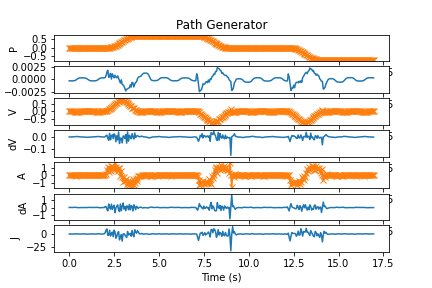

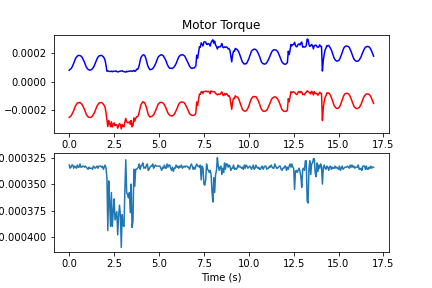

In [46]:
await plot_path_generator(efd_client, time_start, time_stop, filename="small_slew_test")

In [47]:
data_controller_state, data_in_position, data_tracking = await get_event_data(
    efd_client, time_start, time_stop)

In [48]:
data_controller_state

,controllerState,enabledSubstate,time_difference
2022-03-28 16:04:28.585000+00:00,2,1,2.038
2022-03-28 16:04:30.536000+00:00,2,0,3.989
2022-03-28 16:04:33.686000+00:00,2,1,7.139
2022-03-28 16:04:35.587000+00:00,2,0,9.040
2022-03-28 16:04:38.787000+00:00,2,1,12.240
2022-03-28 16:04:40.688000+00:00,2,0,14.141


In [49]:
data_in_position

,inPosition,time_difference
2022-03-28 16:04:28.535000+00:00,False,1.988
2022-03-28 16:04:30.236000+00:00,True,3.689
2022-03-28 16:04:33.637000+00:00,False,7.090
2022-03-28 16:04:35.387000+00:00,True,8.840
2022-03-28 16:04:35.587000+00:00,False,9.040
2022-03-28 16:04:35.637000+00:00,True,9.090
2022-03-28 16:04:38.738000+00:00,False,12.191
2022-03-28 16:04:40.488000+00:00,True,13.941


In [50]:
data_tracking

""


**Test Case (long slew test + constant speed test)**

Test the positive and negative directions.
The behavior of trajectory generator should be the same for these two tests.
Note the CSC does not support the command of constant speed move.

In [58]:
time_start = script_log_start(script, test_title, "long slew / constant speed test")

In [59]:
await slew_test(rotator, 90, 35, 10)

arrived 1
arrived 2
arrived 3


In [60]:
time_stop = script_log_stop(script, test_title, "long slew / constant speed test")

Units: P (deg), V (deg/s), A (deg/s^2), J (deg/s^3), Torque T (N * m)


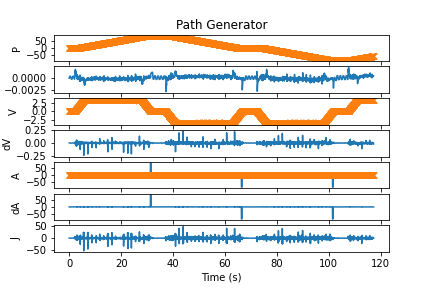

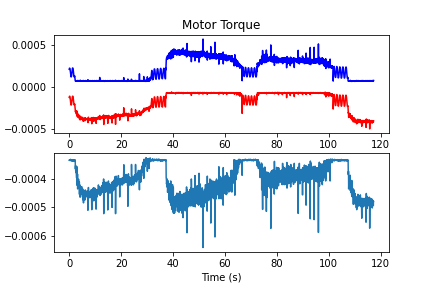

In [62]:
await plot_path_generator(efd_client, time_start, time_stop, filename="long_slew_constant_speed")

In [67]:
data_controller_state, data_in_position, data_tracking = await get_event_data(
    efd_client, time_start, time_stop)

In [68]:
data_controller_state

,controllerState,enabledSubstate,time_difference
2022-03-28 17:02:04.441000+00:00,2,1,2.136
2022-03-28 17:02:33.897000+00:00,2,0,31.592
2022-03-28 17:02:39.498000+00:00,2,1,37.193
2022-03-28 17:03:08.954000+00:00,2,0,66.649
2022-03-28 17:03:14.605000+00:00,2,1,72.300
2022-03-28 17:03:44.061000+00:00,2,0,101.756
2022-03-28 17:03:49.713000+00:00,2,1,107.408


In [69]:
data_in_position

,inPosition,time_difference
2022-03-28 17:02:04.391000+00:00,False,2.086
2022-03-28 17:02:33.647000+00:00,True,31.342
2022-03-28 17:02:39.448000+00:00,False,37.143
2022-03-28 17:03:08.755000+00:00,True,66.450
2022-03-28 17:03:14.556000+00:00,False,72.251
2022-03-28 17:03:43.862000+00:00,True,101.557
2022-03-28 17:03:49.663000+00:00,False,107.358


In [70]:
data_tracking

""


**Test Case (rotation range test)**

Note the CSC does not support the command of constant speed move.

In [ ]:
time_start = script_log_start(script, test_title, "rotation range test")

The configuration file of controller can update the following parameters: Parameters_upperPosLimit_deg, Parameters_lowerPosLimit_deg, Parameters_PositionErrorThresh, Parameters_FollowingErrorThreshold_deg, Parameters_trackingSuccessPositionThreshold_deg, and Parameters_trackingLostTimeout_sec in the Simulink model.

In [ ]:
# Test the move position is out of range
# Need to modify the configuration file in the rotator controller to have the max/min of +/-45 degree
# before the test
try:
    await rotator.cmd_move.set_start(position=46, timeout=60)
except salobj.AckError as error:
    print(error)

try:
    await rotator.cmd_move.set_start(position=-46, timeout=60)
except salobj.AckError as error:
    print(error)

In [ ]:
time_stop = script_log_stop(script, test_title, "rotation range test")

In [ ]:
await plot_path_generator(efd_client, time_start, time_stop, filename="rotation_range")

In [ ]:
data_controller_state, data_in_position, data_tracking = await get_event_data(
    efd_client, time_start, time_stop)

In [ ]:
data_controller_state

In [ ]:
data_in_position

In [ ]:
data_tracking

**Test Case (position accuracy)**

The **slewingAndTracking** operation will be tested.
Note the rotator will transition to Fault state in the final if there is no new track command.
This behaviour can be used to verify the test case of "no tracking commands".
In addition, the trajectory generator will do the extrapolation in a small time period before the transition to **Fault** state.

Target is moving in the positive direction.

In [76]:
time_start = script_log_start(script, test_title, "position accuracy (positive)")

In [77]:
await track_target(rotator, 30, 30.5, 0.03)

In [78]:
time_stop = script_log_stop(script, test_title, "position accuracy (positive)")

Units: P (deg), V (deg/s), A (deg/s^2), J (deg/s^3), Torque T (N * m)


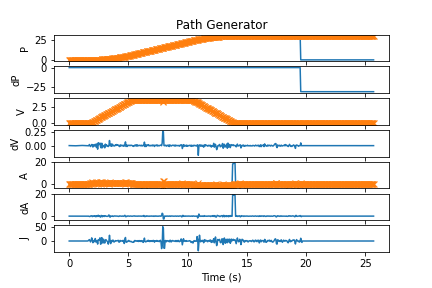

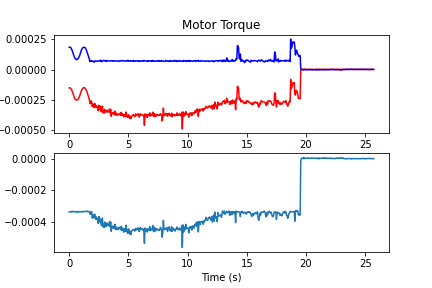

In [79]:
await plot_path_generator(efd_client, time_start, time_stop, filename="position_accuracy_positive")

In [80]:
data_controller_state, data_in_position, data_tracking = await get_event_data(
    efd_client, time_start, time_stop)

In [81]:
data_controller_state

,controllerState,enabledSubstate,time_difference
2022-03-28 17:13:18.835000+00:00,2,2,1.671
2022-03-28 17:13:36.739000+00:00,4,0,19.575


In [82]:
data_in_position

,inPosition,time_difference
2022-03-28 17:13:18.836000+00:00,False,1.672
2022-03-28 17:13:32.588000+00:00,True,15.424
2022-03-28 17:13:33.589000+00:00,False,16.425


In [83]:
data_tracking

,tracking,lost,noNewCommand,time_difference
2022-03-28 17:13:18.836000+00:00,False,True,False,1.672
2022-03-28 17:13:32.588000+00:00,True,False,False,15.424
2022-03-28 17:13:33.589000+00:00,False,False,False,16.425
2022-03-28 17:13:34.589000+00:00,False,True,False,17.425
2022-03-28 17:13:36.739000+00:00,False,False,True,19.575


Target is moving in the negative direction.

In [90]:
time_start = script_log_start(script, test_title, "position accuracy (negative)")

In [91]:
await track_target(rotator, -30, -31.1, -0.068)

In [98]:
time_stop = script_log_stop(script, test_title, "position accuracy (negative)")

Units: P (deg), V (deg/s), A (deg/s^2), J (deg/s^3), Torque T (N * m)


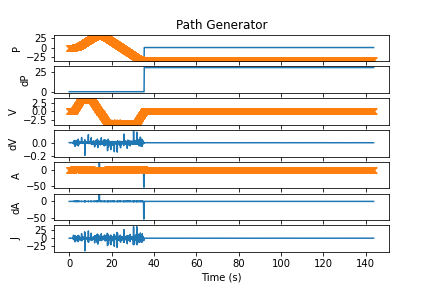

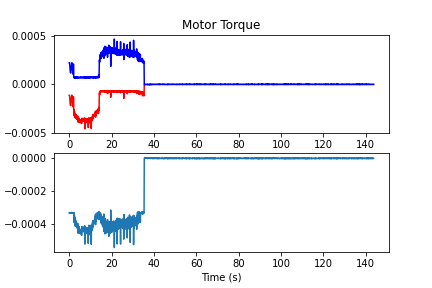

In [99]:
await plot_path_generator(efd_client, time_start, time_stop, filename="position_accuracy_negative")

In [100]:
data_controller_state, data_in_position, data_tracking = await get_event_data(
    efd_client, time_start, time_stop)

In [101]:
data_controller_state

,controllerState,enabledSubstate,time_difference
2022-03-28 17:16:35.878000+00:00,2,2,1.833
2022-03-28 17:17:09.485000+00:00,4,0,35.440


In [102]:
data_in_position

,inPosition,time_difference
2022-03-28 17:16:35.878000+00:00,False,1.833


In [103]:
data_tracking

,tracking,lost,noNewCommand,time_difference
2022-03-28 17:16:35.878000+00:00,False,True,False,1.833
2022-03-28 17:17:09.486000+00:00,False,False,True,35.441


**Test Case (tracking / slewing sequence test)**

Track two targets and stop in between.

In [119]:
time_start = script_log_start(script, test_title, "tracking/slewing sequence test")

In [120]:
await track_slew_test(rotator)

check point 1
check point 2
check point 3
check point 4
check point 5
check point 6


In [122]:
time_stop = script_log_stop(script, test_title, "tracking/slewing sequence test")

Units: P (deg), V (deg/s), A (deg/s^2), J (deg/s^3), Torque T (N * m)


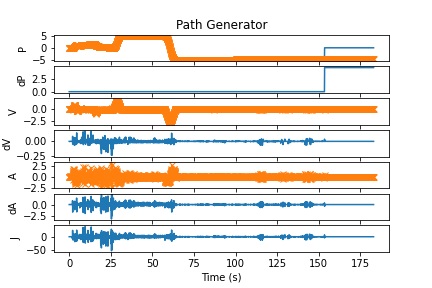

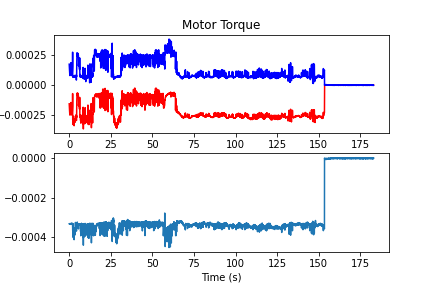

In [123]:
await plot_path_generator(efd_client, time_start, time_stop, filename="tracking_slewing_sequence")

In [131]:
data_controller_state, data_in_position, data_tracking = await get_event_data(
    efd_client, time_start, time_stop)

In [132]:
data_controller_state

,controllerState,enabledSubstate,time_difference
2022-03-28 17:27:07.317000+00:00,2,2,2.093
2022-03-28 17:27:10.517000+00:00,2,3,5.293
2022-03-28 17:27:10.868000+00:00,2,0,5.644
2022-03-28 17:27:11.568000+00:00,2,2,6.344
2022-03-28 17:29:38.852000+00:00,4,0,153.628


In [133]:
data_in_position

,inPosition,time_difference
2022-03-28 17:27:07.317000+00:00,False,2.093
2022-03-28 17:27:40.225000+00:00,True,35.001
2022-03-28 17:27:41.225000+00:00,False,36.001
2022-03-28 17:27:51.377000+00:00,True,46.153
2022-03-28 17:27:52.428000+00:00,False,47.204
2022-03-28 17:28:02.280000+00:00,True,57.056
2022-03-28 17:28:03.730000+00:00,False,58.506
2022-03-28 17:28:10.432000+00:00,True,65.208
2022-03-28 17:28:19.034000+00:00,False,73.810
2022-03-28 17:28:20.234000+00:00,True,75.010


In [134]:
data_tracking

,tracking,lost,noNewCommand,time_difference
2022-03-28 17:27:07.317000+00:00,False,True,False,2.093
2022-03-28 17:27:10.518000+00:00,False,False,False,5.294
2022-03-28 17:27:11.568000+00:00,False,True,False,6.344
2022-03-28 17:27:40.225000+00:00,True,False,False,35.001
2022-03-28 17:27:41.225000+00:00,False,False,False,36.001
2022-03-28 17:27:42.225000+00:00,False,True,False,37.001
2022-03-28 17:27:51.377000+00:00,True,False,False,46.153
2022-03-28 17:27:52.428000+00:00,False,False,False,47.204
2022-03-28 17:27:53.378000+00:00,False,True,False,48.154
2022-03-28 17:28:02.280000+00:00,True,True,False,57.056


**Test Case (tracking without initial slewing)**

No initial slewing is applied to the rotator.

In [135]:
time_start = script_log_start(script, test_title, "tracking w/o initial slewing")

In [136]:
data = await rotator.tel_rotation.aget(timeout=15)
await track_target(rotator, data.actualPosition, data.actualPosition + 0.5, 0.068)

AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=1893430214, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result='Failed: Low-level controller in substate 0.0 instead of 2')

In [137]:
time_stop = script_log_stop(script, test_title, "tracking w/o initial slewing")

Units: P (deg), V (deg/s), A (deg/s^2), J (deg/s^3), Torque T (N * m)


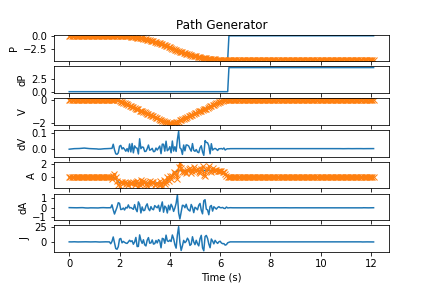

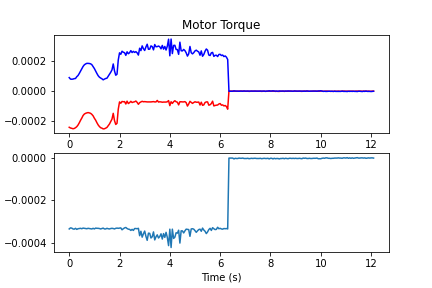

In [138]:
await plot_path_generator(efd_client, time_start, time_stop, filename="tracking_no_initial_slewing")

In [139]:
data_controller_state, data_in_position, data_tracking = await get_event_data(
    efd_client, time_start, time_stop)

In [140]:
data_controller_state

,controllerState,enabledSubstate,time_difference
2022-03-28 17:40:14.393000+00:00,2,2,1.756
2022-03-28 17:40:18.994000+00:00,4,0,6.357


In [141]:
data_in_position

,inPosition,time_difference
2022-03-28 17:40:14.394000+00:00,False,1.757


In [142]:
data_tracking

,tracking,lost,noNewCommand,time_difference
2022-03-28 17:40:14.394000+00:00,False,True,False,1.757
2022-03-28 17:40:18.995000+00:00,False,False,True,6.358


**Test Case (slewing supersession)**

Test the slewing supersession capability of the rotator.

In [154]:
time_start = script_log_start(script, test_title, "slewing supersession")

In [155]:
await slew_supersession_test(rotator)

check point 1
check point 2
check point 3


In [156]:
time_stop = script_log_stop(script, test_title, "slewing supersession")

Units: P (deg), V (deg/s), A (deg/s^2), J (deg/s^3), Torque T (N * m)


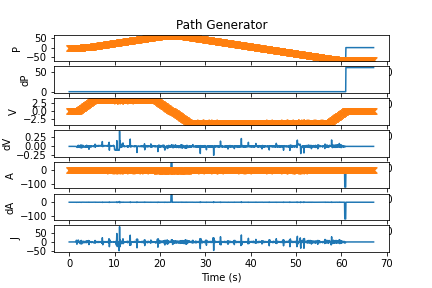

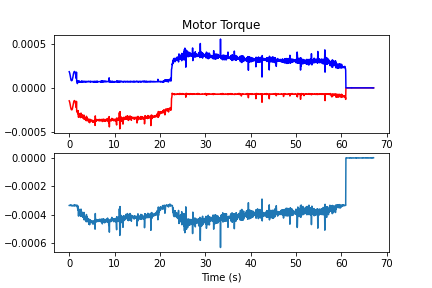

In [157]:
await plot_path_generator(efd_client, time_start, time_stop, filename="slewing_supersession")

In [158]:
data_controller_state, data_in_position, data_tracking = await get_event_data(
    efd_client, time_start, time_stop)

In [159]:
data_controller_state

,controllerState,enabledSubstate,time_difference
2022-03-28 17:45:05.709000+00:00,2,2,1.631
2022-03-28 17:46:05.123000+00:00,4,0,61.045


In [160]:
data_in_position

,inPosition,time_difference
2022-03-28 17:45:05.709000+00:00,False,1.631


In [161]:
data_tracking

,tracking,lost,noNewCommand,time_difference
2022-03-28 17:45:05.710000+00:00,False,True,False,1.632
2022-03-28 17:46:05.123000+00:00,False,False,True,61.045


**Test Case (tracking / slewing with multiple stops)**

In [183]:
time_start = script_log_start(script, test_title, "tracking/slewing with multiple stops")

In [184]:
await track_slew_multiple_stop_test(rotator)

check point 1
check point 2
check point 3
check point 4


In [185]:
time_stop = script_log_stop(script, test_title, "tracking/slewing with multiple stops")

Units: P (deg), V (deg/s), A (deg/s^2), J (deg/s^3), Torque T (N * m)


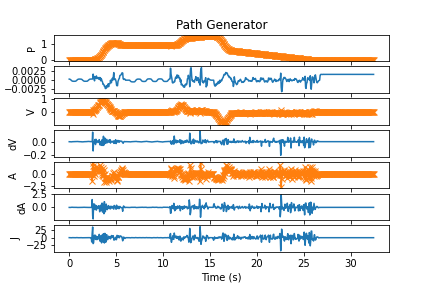

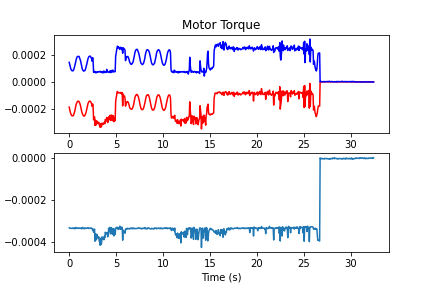

In [187]:
await plot_path_generator(efd_client, time_start, time_stop, filename="tracking_slewing_multiple_stops")

In [188]:
data_controller_state, data_in_position, data_tracking = await get_event_data(
    efd_client, time_start, time_stop)

In [189]:
data_controller_state

,controllerState,enabledSubstate,time_difference
2022-03-28 17:54:05.180000+00:00,2,2,2.524
2022-03-28 17:54:08.381000+00:00,2,3,5.725
2022-03-28 17:54:08.681000+00:00,2,0,6.025
2022-03-28 17:54:13.482000+00:00,2,2,10.826
2022-03-28 17:54:29.436000+00:00,4,0,26.780


In [190]:
data_in_position

,inPosition,time_difference
2022-03-28 17:54:05.181000+00:00,False,2.525
2022-03-28 17:54:17.884000+00:00,True,15.228
2022-03-28 17:54:19.134000+00:00,False,16.478


In [191]:
data_tracking

,tracking,lost,noNewCommand,time_difference
2022-03-28 17:54:05.181000+00:00,False,True,False,2.525
2022-03-28 17:54:08.381000+00:00,False,False,False,5.725
2022-03-28 17:54:13.483000+00:00,False,True,False,10.827
2022-03-28 17:54:17.884000+00:00,True,True,False,15.228
2022-03-28 17:54:17.934000+00:00,True,False,False,15.278
2022-03-28 17:54:19.134000+00:00,False,False,False,16.478
2022-03-28 17:54:20.134000+00:00,False,True,False,17.478
2022-03-28 17:54:29.436000+00:00,False,False,True,26.780
